In [1]:
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import pickle
import json
from database.comet import Comet
from processor.processor import Processor as p
from time import sleep
import matplotlib.pyplot as plt
import math
from backtester.entry import Entry

In [2]:
comet = Comet()

In [3]:
start = datetime(2021,5,10)
end = datetime(2022,1,1)

In [5]:
comet.connect()
prices = comet.retrieve(f"alpha_prices")
comet.disconnect()

In [9]:
prices

,date,open,high,low,close,volume,market_cap,crypto
0,2022-01-09,1.1820,1.1850,1.1720,1.1820,3844276.90000000,3844276.90000000,ADA
1,2022-01-08,1.2090,1.2540,1.1240,1.1810,169730473.68000001,169730473.68000001,ADA
2,2022-01-07,1.2790,1.2850,1.1890,1.2100,209806013.19999999,209806013.19999999,ADA
3,2022-01-06,1.2300,1.2970,1.1860,1.2800,175754407.59999999,175754407.59999999,ADA
4,2022-01-05,1.3100,1.3530,1.1930,1.2300,158740088.19999999,158740088.19999999,ADA
...,...,...,...,...,...,...,...,...
8816,2020-08-22,2.8387,4.5500,2.7820,4.4546,41611476.51000000,41611476.51000000,DOT
8817,2020-08-21,2.8978,3.0900,2.6826,2.8330,9765153.74000000,9765153.74000000,DOT
8818,2020-08-20,2.9449,3.1111,2.6000,2.9000,11040863.60000000,11040863.60000000,DOT
8819,2020-08-19,3.1000,3.1999,2.6400,2.9500,15895774.92000000,15895774.92000000,DOT


In [8]:
symbols = ['ADA', 'BTC', 'DOGE', 'ETH', 'SHIB', 'LUNA',
       'AVAX', 'LTC', 'DOT']

In [14]:
prices

,date,open,high,low,close,volume,market_cap,crypto
0,2022-01-09,1.1820,1.1850,1.1720,1.1820,3844276.90000000,3844276.90000000,ADA
1,2022-01-08,1.2090,1.2540,1.1240,1.1810,169730473.68000001,169730473.68000001,ADA
2,2022-01-07,1.2790,1.2850,1.1890,1.2100,209806013.19999999,209806013.19999999,ADA
3,2022-01-06,1.2300,1.2970,1.1860,1.2800,175754407.59999999,175754407.59999999,ADA
4,2022-01-05,1.3100,1.3530,1.1930,1.2300,158740088.19999999,158740088.19999999,ADA
...,...,...,...,...,...,...,...,...
8816,2020-08-22,2.8387,4.5500,2.7820,4.4546,41611476.51000000,41611476.51000000,DOT
8817,2020-08-21,2.8978,3.0900,2.6826,2.8330,9765153.74000000,9765153.74000000,DOT
8818,2020-08-20,2.9449,3.1111,2.6000,2.9000,11040863.60000000,11040863.60000000,DOT
8819,2020-08-19,3.1000,3.1999,2.6400,2.9500,15895774.92000000,15895774.92000000,DOT


In [53]:
api = "alpha"
retrack_days = [1,3,7,14]
signals = range(0,15,5)
reqs = range(5,35,5)
trades = []
comet.connect()
prices = comet.retrieve(f"{api}_prices")
comet.disconnect()
market = prices.pivot_table(index="date",columns="crypto",values="close").reset_index()
market = p.column_date_processing(market)
market = market.fillna(method="ffill")
start = datetime(2021,10,1)
end = datetime(2022,1,1)
for value in [True,False]:
    for rt in tqdm(retrack_days):
        sim = market.melt(id_vars="date").copy()
        ns = []
        for crypto in sim["crypto"].unique():
            crypto_sim = sim[sim["crypto"]==crypto].copy()
            crypto_sim.sort_values("date",inplace=True)
            crypto_sim["signal"] = crypto_sim["value"].pct_change(rt)
            crypto_sim["velocity"] = crypto_sim["signal"].pct_change(rt)
            crypto_sim["inflection"] = crypto_sim["velocity"].pct_change(rt)
            ns.append(crypto_sim)
        final = pd.concat(ns)
        for symbol in symbols:
            for s in tqdm(signals):
                for r in reqs:
                    signal = float(s/100)
                    req = float(r/100)
                    date = start
                    while date < end:
                        try:
                            if value:
                                offerings = final[(final["date"]==date) 
                                                  & (final["signal"] <= -signal)
                                                  & (final["crypto"] == symbol)
                                                  & (final["velocity"] >= -3)
                                                  & (final["velocity"] < 0)
                                                   & (final["inflection"] >= -1)
                                                  & (final["inflection"] <= 1)].sort_values("signal",ascending=False)
                            else:
                                offerings = final[(final["date"]==date) 
                                                  & (final["signal"] >= signal)
                                                  & (final["crypto"] == symbol)
                                                 & ((final["velocity"] > 0))
                                               & ((final["inflection"] <= 1)
                                              | (final["inflection"] >= -1)
                                                 )].sort_values("signal",ascending=False)
                            if offerings.index.size < 1:
                                date = date + timedelta(days=1)
                            else:
                                trade = offerings.iloc[0]
                                symbol = trade["crypto"]
                                exits = final[(final["date"]>trade["date"]) & (final["crypto"]==symbol)]
                                bp = trade["value"]
                                exits["delta"] = (exits["value"] - bp) / bp
                                profits = exits[(exits["delta"] >= req) & (exits["date"] <= trade["date"]+timedelta(days=rt))]
                                breakeven = exits[exits["delta"]>=0 & (exits["date"] > trade["date"]+timedelta(days=rt))]
                                if profits.index.size < 1:
                                    if breakeven.index.size < 1:
                                        exit = exits.iloc[-1]
                                        trade["sell_price"] = exit["value"]
                                    else:
                                        exit = breakeven.iloc[0]
                                        trade["sell_price"] = bp
                                else:
                                    exit = profits.iloc[0]
                                    trade["sell_price"] = exit["value"]
                                trade["sell_date"] = exit["date"]
                                trade["buy_price"] = bp
                                trade["delta"] = (trade["sell_price"] - trade["buy_price"])/ trade["buy_price"]
                                trade["signal"] = signal
                                trade["req"] = req
                                trade["symbol"] = symbol
                                trade["retrack_days"] = rt
                                trade["value"] = value
                                trades.append(trade)
                                date = exit["date"] + timedelta(days=1)
                        except Exception as e:
                            print(date,str(e))
                            date = date + timedelta(days=1)

100%|██████████████████████████| 3/3 [00:02<00:00,  1.10it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.10it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.09it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.10it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.11it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.11it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.11it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.11it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.10it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.09it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.10it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.11it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.11it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.11it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.11it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.1

100%|██████████████████████████| 3/3 [00:02<00:00,  1.17it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.17it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.14it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.15it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.17it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.17it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.17it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.18it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.17it/s]

100%|██████████████████████████| 3/3 [00:02<00:00,  1.17it/s]

100%|██████████████████████████| 4/4 [01:32<00:00, 23.12s/it]


In [54]:
t = pd.DataFrame(trades)

In [55]:
t

""


In [56]:
analysis = []
for value in [True,False]:
    for symbol in tqdm(symbols):
        for rt in retrack_days:
            for s in tqdm(signals):
                for r in reqs:
                    try:
                        signal = float(s/100)
                        req = float(r/100)
                        iteration_trades = t[(t["symbol"] == symbol) & (t["signal"]==signal) & (t["req"]==req) & (t["retrack_days"]==rt) & (t["value"]==value)]
                        initial = 100
                        for delta in iteration_trades["delta"]:
                             initial = initial * (1+delta)
                        iteration_trades["hpr"] = iteration_trades["sell_date"] - iteration_trades["date"]
                        iteration_trades["days"] = [x.days for x in iteration_trades["hpr"]]
                        days = iteration_trades["days"].mean()
                        analysis.append({"symbol":symbol,"signal":signal,"req":req,"trades":iteration_trades.index.size,"pv":initial,"days":days,"retrack_days":rt,"api":api})
                    except Exception as e:
                        print(str(e))

100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 3000.93it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2999.50it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2999.50it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2998.79it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 3000.22it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 3000.22it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|█████████████████████████| 9/9 [00:00<00:00, 105.86it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'


100%|████████████████████████| 3/3 [00:00<00:00, 2998.79it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2999.50it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2999.50it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2999.50it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2999.50it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2998.79it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|█████████████████████████| 3/3 [00:00<00:00, 157.86it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2999.50it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2999.50it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2998.79it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2999.50it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]

'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 3000.22it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 3000.93it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2998.07it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 3000.93it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2997.36it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 3003.08it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|████████████████████████| 3/3 [00:00<00:00, 2999.50it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████████████| 3/3 [00:00<?, ?it/s]


'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'



100%|██████████████████████████| 9/9 [00:00<00:00, 35.71it/s]

'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'
'symbol'


In [57]:
a = pd.DataFrame(analysis)
a.sort_values("pv",ascending=False).head(50)

KeyError: 'pv'

In [ ]:
best_iterations = []
for symbol in symbols:
    try:
        current = a[(a["api"]==api) & (a["symbol"]==symbol)].sort_values("pv",ascending=False).iloc[0]
        best_iterations.append(current)
    except:
        continue
performance = pd.DataFrame(best_iterations)
performance.sort_values("pv",ascending=False)

In [ ]:
performance.to_csv("./data/report.csv")

In [ ]:
for symbol in performance["symbol"].unique():
    for api in ["tiingo","alpha"]:
        goods = performance[(performance["symbol"]==symbol) & (performance["api"]==api)]
        current_trades = t[(t["symbol"]==symbol) 
                           & (t["signal"]==goods["signal"].item())
                               & (t["req"]==goods["req"].item())
                                & (t["retrack_days"]==goods["retrack_days"].item())
                                  & (t["api"]==api)
                          ]
        if current_trades.index.size > 1:
            viz = []
            row = current_trades.iloc[0]
            pv = 100
            start_date = row["date"]
            amount = float(pv/row["buy_price"])
            end_date = row["sell_date"]
            pv2 = amount * row["sell_price"]
            viz.append({"date":start_date,"amount":amount})
            viz.append({"date":end_date,"amount":amount})
            track_date = start_date
            while track_date < end_date - timedelta(days=1):
                track_date = track_date + timedelta(days=1)
                viz.append({"date":track_date,"amount":amount})
            for i in range(1,current_trades.index.size-1):
                row = current_trades.iloc[i]
                prev = current_trades.iloc[i-1]
                start_date = row["date"]
                pv = pv2
                amount =  pv /row["buy_price"]
                viz.append({"date":start_date,"amount":amount})
                track_date = start_date
                end_date = row["sell_date"]
                while track_date < end_date:
                    track_date = track_date + timedelta(days=1)
                    viz.append({"date":track_date,"amount":amount})
                pv2 = amount * row["sell_price"]
                viz.append({"date":end_date,"amount":amount})
            window = pd.DataFrame(viz)
            example = market.merge(window,how="left",on="date")
            example = example[example["date"]>=start]
            example["actual"] = example["amount"] * example[symbol]
            example = example.fillna(method="bfill")
            example["actual_delta"] = (example["actual"] - 100) / 100
            example["benchmark_delta"] = (example[symbol] - example[symbol].iloc[0]) / example[symbol].iloc[0] 
            if example["actual"].max() < 10000:
                plt.plot(example["date"],example["actual_delta"])
                plt.plot(example["date"],example["benchmark_delta"])
    plt.title(symbol)
    plt.legend(["tiingo","alpha"])
    plt.show()

In [73]:
market.dropna()

crypto,date,ada,avax,btc,cake,doge,dot,eth,ltc,luna,shib,xrp,xtz
755,2021-05-10,1.6423,34.652,55816.14,35.982,0.45074,36.488,3945.88,358.89,15.850,0.000035,1.3906,6.1917
756,2021-05-11,1.7632,36.800,56670.02,36.814,0.49326,38.637,4173.45,377.60,16.310,0.000030,1.4786,7.1247
757,2021-05-12,1.5694,32.800,49631.32,29.303,0.39160,35.128,3823.21,310.40,14.619,0.000018,1.2691,5.9392
758,2021-05-13,1.9296,35.075,49670.97,29.566,0.48945,39.988,3717.91,317.95,15.911,0.000021,1.3640,6.1252
759,2021-05-14,2.0069,36.999,49841.45,31.638,0.55971,47.979,4075.01,326.23,16.403,0.000018,1.4000,6.4737
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-01-05,1.2300,97.420,43451.13,11.280,0.15900,26.720,3540.63,135.40,78.470,0.000030,0.7726,4.5090
996,2022-01-06,1.2800,95.110,43082.31,11.080,0.15990,26.720,3406.81,135.90,78.410,0.000031,0.7791,4.4520
997,2022-01-07,1.2100,86.740,41566.48,10.440,0.15500,24.900,3199.24,131.40,68.800,0.000029,0.7634,4.2530
998,2022-01-08,1.1810,83.900,41679.74,10.220,0.15090,23.990,3080.95,129.40,66.960,0.000028,0.7452,4.0050


In [356]:
t = pd.DataFrame(trades)

In [215]:
# from derivative import dxdt
# import numpy as np
# research = final[final["crypto"]=="btc"].dropna()
# t = research.index
# x = research["value"]

# # 1. Finite differences with central differencing using 3 points.
# result1 = dxdt(x, t, kind="finite_difference", k=3)
# result2 = dxdt(result1, t, kind="finite_difference", k=3)
# result3 = dxdt(result2, t, kind="finite_difference", k=3)
# research = research.iloc[3:]
# research["d1"] = result1[3:]
# research["d2"] = result2[3:]
# research["d3"] = result3[3:]
# # 2. Savitzky-Golay using cubic polynomials to fit in a centered window of length 1
# result2 = dxdt(x, t, kind="savitzky_golay", left=.5, right=.5, order=3)

# # 3. Spectral derivative
# result3 = dxdt(x, t, kind="spectral")

# # 4. Spline derivative with smoothing set to 0.01
# result4 = dxdt(x, t, kind="spline", s=1e-2)

# # 5. Total variational derivative with regularization set to 0.01
# result5 = dxdt(x, t, kind="trend_filtered", order=0, alpha=1e-2)

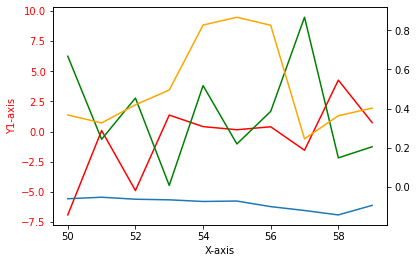

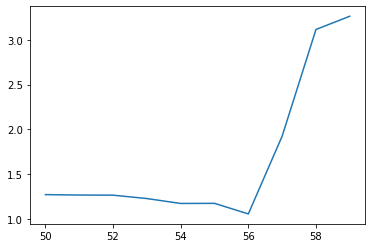

In [354]:
research = final.copy()
research["p1"] = research["value"].pct_change(3)
research["p2"] = research["p1"].pct_change(3)
research["p3"] = research["p2"].pct_change(3)
research["p_sign_change"] = [row[1]["p2"] * row[1]["p3"] < 0 for row in research.iterrows()]
research["delta"] = (research["value"].shift(-28) - research["value"]) / research["value"]
research.reset_index(drop=True,inplace=True)
window = research[(research["p1"]<-0.05) * (research["delta"]>0.2)].reset_index().iloc[50:60]
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('X-axis') 
ax1.set_ylabel('Y1-axis', color = 'red') 
ax1.plot(window["p2"], color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
ax1.plot(window["p3"], color = 'green') 
# Adding Twin Axes

ax2 = ax1.twinx() 
ax2.plot(window["p1"])
ax2.plot(window["delta"],color="orange")
# plt.plot(window["p2"])
# plt.plot(window["p3"])
# plt.legend([1,2,3])
plt.show()
plt.plot(window["value"])

In [350]:
window[window["delta"]>0].index.size / window.index.size

1.0

In [373]:
sim

,date,crypto,value
0,2019-04-16,ada,0.08271
1,2019-04-17,ada,0.08244
2,2019-04-18,ada,0.08118
3,2019-04-19,ada,0.07884
4,2019-04-20,ada,0.07597
...,...,...,...
11995,2022-01-05,xtz,4.50900
11996,2022-01-06,xtz,4.45200
11997,2022-01-07,xtz,4.25300
11998,2022-01-08,xtz,4.00500


In [385]:
api = "alpha"
retrack_days = [1,3,7,14]
signals = range(0,15,5)
reqs = range(5,35,5)
trades = []
comet.connect()
prices = comet.retrieve(f"{api}_prices")
comet.disconnect()
market = prices.pivot_table(index="date",columns="crypto",values="close").reset_index()
market = p.column_date_processing(market)
market = market.fillna(method="ffill")
start = datetime(2021,1,1)
end = datetime(2022,1,1)
for conservative in [True,False]:
    for value in [True,False]:
        for rt in tqdm(retrack_days):
            sim = market.melt(id_vars="date").copy()
            ns = []
            for crypto in sim["crypto"].unique():
                crypto_sim = sim[sim["crypto"]==crypto].copy()
                crypto_sim.sort_values("date",inplace=True)
                crypto_sim["signal"] = crypto_sim["value"].pct_change(rt)
                crypto_sim["velocity"] = crypto_sim["signal"].pct_change(rt)
                crypto_sim["inflection"] = crypto_sim["velocity"].pct_change(rt)
                crypto_sim["p_sign_change"] = [row[1]["velocity"] * row[1]["inflection"] < 0 for row in crypto_sim.iterrows()]
                ns.append(crypto_sim)
            final = pd.concat(ns)
            final = final[(final["date"] < end) & (final["crypto"].isin([x.lower() for x in symbols]))]
            for s in tqdm(signals):
                for r in reqs:
                    signal = float(s/100)
                    req = float(r/100)
                    date = start
                    while date < end:
                        try:
                            offerings = Entry.signal_based(final,date,signal,value,conservative)
                            if offerings.index.size < 1:
                                date = date + timedelta(days=1)
                            else:
                                trade = offerings.iloc[0]
                                symbol = trade["crypto"]
                                exits = final[(final["date"]>trade["date"]) & (final["crypto"]==symbol)]
                                bp = trade["value"]
                                due_date = trade["date"]+timedelta(days=rt)
                                exits["delta"] = (exits["value"] - bp) / bp
                                profits = exits[(exits["delta"] >= req) & (exits["date"] <= due_date)]
                                breakeven = exits[(exits["delta"]>=0) & (exits["date"] > due_date)]
                                if profits.index.size < 1:
                                    if breakeven.index.size < 1:
                                        exit = exits[(exits["date"] > due_date)].iloc[-1]
                                        trade["sell_price"] = exit["value"]
                                        trade["type"] = "loss"
                                    else:
                                        exit = breakeven.iloc[0]
                                        trade["type"] = "breakeven"
                                        trade["sell_price"] = bp
                                else:
                                    exit = profits.iloc[0]
                                    trade["type"] = "profit"
                                    trade["sell_price"] = exit["value"]
                                trade["sell_date"] = exit["date"]
                                trade["buy_price"] = bp
                                trade["delta"] = (trade["sell_price"] - trade["buy_price"])/ trade["buy_price"]
                                trade["signal"] = signal
                                trade["req"] = req
                                trade["symbol"] = symbol
                                trade["retrack_days"] = rt
                                trade["value"] = value
                                trade["conservative"] = conservative
                                trades.append(trade)
                                date = exit["date"] + timedelta(days=1)
                        except Exception as e:
                            print(date,str(e))
                            date = date + timedelta(days=1)

  0%|                                  | 0/3 [00:00<?, ?it/s]C:\Users\eric\AppData\Local\Temp/ipykernel_13868/2636901061.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exits["delta"] = (exits["value"] - bp) / bp
C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value i

2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-27 00:00:00 single positional indexer is out-of-bounds
2021-12-28 00:00:00 single positional indexer is out-of-bounds



100%|██████████████████████████| 4/4 [00:10<00:00,  2.56s/it]


In [386]:
t = pd.DataFrame(trades)

In [387]:
analysis = []
api = "alpha"
for conservative in [True,False]:
    for value in [True,False]:
        for rt in retrack_days:
            for s in tqdm(signals):
                for r in reqs:
                    try:
                        signal = float(s/100)
                        req = float(r/100)
                        iteration_trades = t[(t["signal"]==signal) & (t["req"]==req) & (t["retrack_days"]==rt) & (t["value"]==value) & (t["conservative"]==conservative)]
                        initial = 100
                        for delta in iteration_trades["delta"]:
                             initial = initial * (1+delta)
                        iteration_trades["hpr"] = iteration_trades["sell_date"] - iteration_trades["date"]
                        iteration_trades["days"] = [x.days for x in iteration_trades["hpr"]]
                        days = iteration_trades["days"].mean()
                        analysis.append({"signal":signal,"req":req,"trades":iteration_trades.index.size,"pv":initial,"days":days,"retrack_days":rt,"value":value,"conservative":conservative})
                    except Exception as e:
                        print(str(e))

  0%|                                  | 0/3 [00:00<?, ?it/s]C:\Users\eric\AppData\Local\Temp/ipykernel_13868/618375420.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iteration_trades["hpr"] = iteration_trades["sell_date"] - iteration_trades["date"]
C:\Users\eric\AppData\Local\Temp/ipykernel_13868/618375420.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iteration_trades["days"] = [x.days for x in iteration_trades["hpr"]]
100%|█████████████████████████| 3/3 [00:00<00:00, 107.10it/s]


In [393]:
a = pd.DataFrame(analysis)
a.sort_values("pv",ascending=False).head(20)

,signal,req,trades,pv,days,retrack_days,value,conservative
104,0.10,0.15,38,8110.864421,7.921053,3,False,True
105,0.10,0.20,38,5912.241151,7.973684,3,False,True
92,0.00,0.15,27,2488.647568,12.370370,3,False,True
106,0.10,0.25,34,1605.300028,9.058824,3,False,True
269,0.10,0.30,19,1016.906913,16.842105,7,False,False
241,0.05,0.10,24,1006.359557,14.166667,3,False,False
98,0.05,0.15,20,956.796147,17.200000,3,False,True
97,0.05,0.10,20,914.135554,17.150000,3,False,True
103,0.10,0.10,19,783.496325,18.000000,3,False,True
91,0.00,0.10,19,697.071045,18.105263,3,False,True


C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


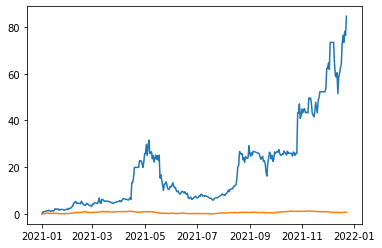

In [389]:
api = "alpha"
goods = a.sort_values("pv",ascending=False).head(10).iloc[0]
current_trades = t[(t["signal"]==goods["signal"].item())
                       & (t["req"]==goods["req"].item())
                        & (t["retrack_days"]==goods["retrack_days"].item())
                          & (t["value"]==goods["value"].item())
                            & (t["conservative"]==goods["conservative"].item())
                  ]
current_trades.sort_values("sell_date",inplace=True)
if current_trades.index.size > 1:
    viz = []
    row = current_trades.iloc[0]
    pv = 100
    start_date = row["date"]
    symbol = row["symbol"]
    amount = float(pv/row["buy_price"])
    end_date = row["sell_date"]
    pv2 = amount * row["sell_price"]
    viz.append({"date":start_date,"crypto":symbol,"amount":amount})
    viz.append({"date":end_date,"crypto":symbol,"amount":amount})
    track_date = start_date
    while track_date < end_date - timedelta(days=1):
        track_date = track_date + timedelta(days=1)
        viz.append({"date":track_date,"crypto":symbol,"amount":amount})
    for i in range(1,current_trades.index.size-1):
        row = current_trades.iloc[i]
        symbol = current_trades.iloc[i]["symbol"]
        start_date = row["date"]
        pv = pv2
        amount =  pv /row["buy_price"]
        viz.append({"date":start_date,"crypto":symbol,"amount":amount})
        track_date = start_date
        end_date = row["sell_date"]
        while track_date < end_date:
            track_date = track_date + timedelta(days=1)
            viz.append({"date":track_date,"crypto":symbol,"amount":amount})
        pv2 = amount * row["sell_price"]
        viz.append({"date":end_date,"crypto":symbol,"amount":amount})
    window = pd.DataFrame(viz)
    example = final.merge(window,how="left",on=["date","crypto"])
    example = example.dropna().sort_values("date")
    example["actual"] = example["amount"] * example["value"]
    example = example.merge(market[["date","btc"]],on="date",how="left")
    example["bench_delta"] = (example["btc"] - example["btc"].iloc[0]) / example["btc"].iloc[0]
    example["actual_delta"] = (example["actual"] - example["actual"].iloc[0]) / example["actual"].iloc[0]
    if example["actual"].max() < 10000:
        plt.plot(example["date"],example["actual_delta"])
        plt.plot(example["date"],example["bench_delta"])
plt.show()

In [390]:
symbol_analysis = []
for symbol in current_trades["crypto"].unique():
    symbol_trades = current_trades[current_trades["crypto"]==symbol]
    trades = symbol_trades.index.size
    initial = 1
    for delta in symbol_trades["delta"]:
        initial = initial * 1+delta
    symbol_return = initial
    symbol_trades["hpr"] = symbol_trades["sell_date"] - symbol_trades["date"]
    symbol_trades["days"] = [x.days for x in symbol_trades["hpr"]]
    symbol_analysis.append({"symbol":symbol,"return":initial,"trades":trades,"hpr":symbol_trades["days"].mean()})

C:\Users\eric\AppData\Local\Temp/ipykernel_13868/922708580.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_trades["hpr"] = symbol_trades["sell_date"] - symbol_trades["date"]
C:\Users\eric\AppData\Local\Temp/ipykernel_13868/922708580.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_trades["days"] = [x.days for x in symbol_trades["hpr"]]


In [391]:
pd.DataFrame(symbol_analysis).sort_values("return",ascending=False)

,symbol,return,trades,hpr
0,doge,3.939889,5,1.400000
3,avax,1.911578,6,20.166667
4,luna,1.786030,12,6.166667
8,shib,1.648457,2,2.500000
1,eth,1.235250,2,3.500000
2,ada,1.000000,2,10.500000
5,ltc,1.000000,3,10.666667
7,btc,1.000000,1,5.000000
6,dot,0.947406,5,5.800000


In [392]:
current_trades

,date,crypto,value,signal,velocity,inflection,p_sign_change,type,sell_price,sell_date,buy_price,delta,req,symbol,retrack_days,conservative
4626,2021-01-01,doge,False,0.1,-100.320709,98.047553,True,profit,0.010526,2021-01-02,0.005680,0.853239,0.15,doge,3,True
6628,2021-01-03,eth,False,0.1,38.914502,-41.953534,True,profit,1208.420000,2021-01-06,978.280000,0.235250,0.15,eth,3,True
632,2021-01-07,ada,False,0.1,0.145917,-1.032368,True,breakeven,0.299280,2021-01-13,0.299280,0.000000,0.15,ada,3,True
1639,2021-01-14,avax,False,0.1,2.250543,-4.730091,True,profit,12.842100,2021-01-16,9.317700,0.378248,0.15,avax,3,True
642,2021-01-17,ada,False,0.1,0.674289,-1.278661,True,breakeven,0.380810,2021-02-01,0.380810,0.000000,0.15,ada,3,True
1658,2021-02-02,avax,False,0.1,0.493394,-1.282107,True,profit,17.897300,2021-02-05,13.470300,0.328649,0.15,avax,3,True
4662,2021-02-06,doge,False,0.1,76.990137,-158.722137,True,profit,0.077925,2021-02-07,0.057656,0.351548,0.15,doge,3,True
8664,2021-02-08,luna,False,0.1,3.539828,-6.401236,True,breakeven,5.774300,2021-02-16,5.774300,0.000000,0.15,luna,3,True
8673,2021-02-17,luna,False,0.1,9.851520,-7.385007,True,breakeven,7.272300,2021-03-04,7.272300,0.000000,0.15,luna,3,True
8689,2021-03-05,luna,False,0.1,2.166050,-2.173507,True,breakeven,8.461900,2021-03-09,8.461900,0.000000,0.15,luna,3,True
